In [22]:
import numpy as np
import tensorflow as tf
import pickle
import matplotlib.pyplot as plt
import random
import csv
from sklearn.utils import shuffle
from tensorflow.contrib.layers import flatten
from skimage import transform as transf
from sklearn.model_selection import train_test_split
import cv2
from prettytable import PrettyTable
%matplotlib inline
SEED = 2019

In [23]:
# 导入数据并可视化
training_file = 'data/train.p'
testing_file = 'data/test.p'

with open(training_file,mode='rb') as f:
    train = pickle.load(f)
with open(testing_file,mode='rb') as f:
    test = pickle.load(f)

X_train,y_train = train['features'],train['labels']
X_test,y_test = test['features'],test['labels']

# Dataset Summary and Expoloration

In [24]:
n_train = len(X_train)
n_test = len(X_test)

_,IMG_HEIGHT,IMG_WIDTH,IMG_DEPTH = X_train.shape
image_shape = (IMG_HEIGHT,IMG_WIDTH,IMG_DEPTH)

with open('signnames.csv','r') as sign_name:
    reader = csv.reader(sign_name)
    sign_names = list(reader)

sign_names = sign_names[1::]
NUM_CLASSES = len(sign_names)
print('Total number of classes:{}'.format(NUM_CLASSES))

n_classes = len(np.unique(y_train))
assert (NUM_CLASSES== n_classes) ,'1 or more class(es) not represented in training set'

n_test = len(y_test)

print('Number of training examples =',n_train)
print('Number of testing examples =',n_test)
print('Image data shape=',image_shape)
print('Number of classes =',n_classes)

Total number of classes:43
Number of training examples = 34799
Number of testing examples = 12630
Image data shape= (32, 32, 3)
Number of classes = 43


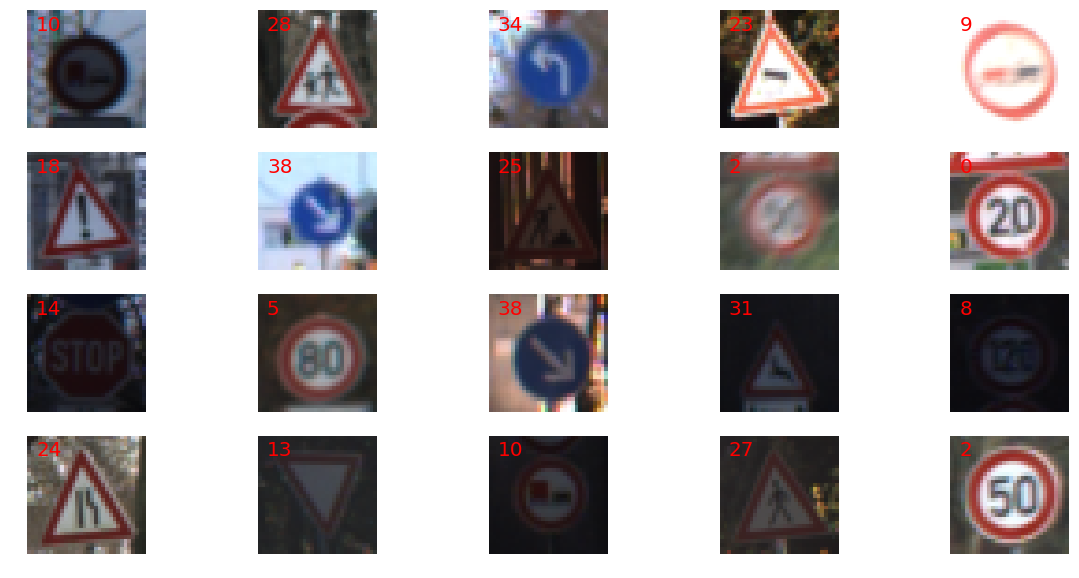

In [25]:
#data visualization,show 20 images
def visualize_random_images(list_imgs,X_dataset,y_dataset):
    #list_imgs:20 index
    _,ax = plt.subplots(len(list_imgs)//5,5,figsize=(20,10))
    row,col = 0,0
    for idx in list_imgs:
        img = X_dataset[idx]
        ax[row,col].imshow(img)
        ax[row,col].annotate(int(y_dataset[idx]),xy=(2,5),color='red',fontsize='20')
        ax[row,col].axis('off')
        col+=1
        if col==5:
            row,col = row+1,0
    plt.show()
ls = [random.randint(0,len(y_train)) for i in range(20)]
visualize_random_images(ls,X_train,y_train)

------- 
Highest count: 2010.0 (class 2)
Lowest count: 180.0 (class 0)
------- 


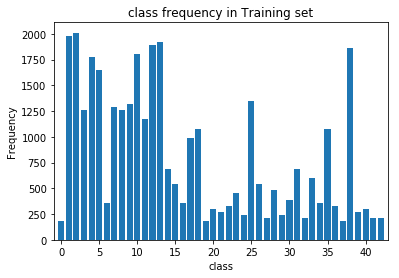

+-------------+----------------------------------------------------+
| class value |                Name of Traffic sign                |
+-------------+----------------------------------------------------+
|      0      |                Speed limit (20km/h)                |
|      1      |                Speed limit (30km/h)                |
|      2      |                Speed limit (50km/h)                |
|      3      |                Speed limit (60km/h)                |
|      4      |                Speed limit (70km/h)                |
|      5      |                Speed limit (80km/h)                |
|      6      |            End of speed limit (80km/h)             |
|      7      |               Speed limit (100km/h)                |
|      8      |               Speed limit (120km/h)                |
|      9      |                     No passing                     |
|      10     |    No passing for vehicles over 3.5 metric tons    |
|      11     |       Right-of-way

In [26]:
def get_count_imgs_per_class(y, verbose=False):
    num_classes = len(np.unique(y))
    count_imgs_per_class = np.zeros( num_classes )

    for this_class in range( num_classes ):
        if verbose: 
            print('class {} | count {}'.format(this_class, np.sum( y  == this_class )) )
        count_imgs_per_class[this_class] = np.sum(y == this_class )
    #sanity check
    return count_imgs_per_class
class_freq = get_count_imgs_per_class(y_train)
print('------- ')
print('Highest count: {} (class {})'.format(np.max(class_freq), np.argmax(class_freq)))
print('Lowest count: {} (class {})'.format(np.min(class_freq), np.argmin(class_freq)))
print('------- ')
plt.bar(np.arange(NUM_CLASSES), class_freq , align='center')
plt.xlabel('class')
plt.ylabel('Frequency')
plt.xlim([-1, 43])
plt.title("class frequency in Training set")
plt.show()
sign_name_table = PrettyTable()
sign_name_table.field_names = ['class value', 'Name of Traffic sign']
for i in range(len(sign_names)):
    sign_name_table.add_row([sign_names[i][0], sign_names[i][1]] )
    
print(sign_name_table)

Histogram of selected images from the class38 ......


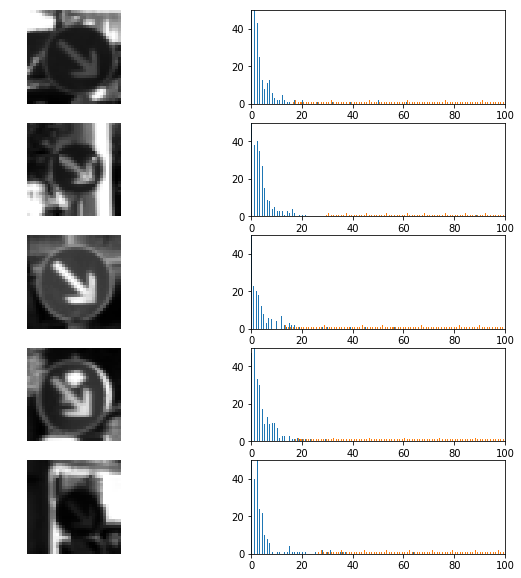

In [27]:
def histograms_randImgs(label,channel,n_imgs=5,ylim=50):
    '''
    Histogram (pixel intensity distribution) for a selection of images with the same label.
    For better visualization, the images are shown in grayscale
    label - the label of the images
    n_imgs - number of images to show (default=5)
    channel - channel used to compute histogram
    ylim - range of y axis values for histogram plot (default=50)
    '''
    assert channel < 3,'image are RGB,choose channel value between in the range[0,2]'
    assert (np.sum(y_train==label))>=n_imgs,'reduce your number of images'
    
    all_imgs = np.ravel(np.argwhere(y_train==label))
    
    #随机选择5张图片
    ls_idx = np.random.choice(all_imgs,size=n_imgs,replace=False)
    _,ax = plt.subplots(n_imgs,2,figsize=(10,10))
    print('Histogram of selected images from the class{} ......'.format(label))
    row,col = 0,0
    for idx in ls_idx:
        img = X_train[idx,:,:,channel]
        #print(img.shape)
        ax[row,col].imshow(img,cmap='gray')
        ax[row,col].axis('off')
        
        hist = np.histogram(img,bins=256)
        ax[row,col+1].hist(hist,bins=256)
        ax[row,col+1].set_xlim([0,100])
        ax[row,col+1].set_ylim([0,ylim])
        col,row = 0,row+1
    plt.show()
histograms_randImgs(38,1)

# Data Augmentation

In [28]:
def random_transform(img,angle_range=[-10,10],
                    scale_range=[0.8,1.2],
                    translation_range=[-3,3]):
    '''
    The function takes an image and performs a set of random affine transformation.
    img:original images
    ang_range:angular range of the rotation [-15,+15] deg for example
    scale_range: [0.8,1.2]
    shear_range:[10,-10]
    translation_range:[-2,2]
    '''
    img_height,img_width,img_depth = img.shape
    # Generate random parameter values
    angle_value = np.random.uniform(low=angle_range[0],high=angle_range[1],size=None)
    scaleX = np.random.uniform(low=scale_range[0],high=scale_range[1],size=None)
    scaleY = np.random.uniform(low=scale_range[0],high=scale_range[1],size=None)
    translationX = np.random.randint(low=translation_range[0],high=translation_range[1]+1,size=None)
    translationY = np.random.randint(low=translation_range[0],high=translation_range[1]+1,size=None)
    
    center_shift = np.array([img_height,img_width])/2. - 0.5
    transform_center = transf.SimilarityTransform(translation=-center_shift)
    transform_uncenter = transf.SimilarityTransform(translation=center_shift)
    
    transform_aug = transf.AffineTransform(rotation=np.deg2rad(angle_value),
                                          scale=(1/scaleY,1/scaleX),
                                          translation = (translationY,translationX))
    #Image transformation : includes rotation ,shear,translation,zoom
    full_tranform = transform_center + transform_aug + transform_uncenter
    new_img = transf.warp(img,full_tranform,preserve_range=True)
    
    return new_img.astype('uint8')

def data_augmentation(X_dataset,y_dataset,augm_nbr,keep_dist=True):
    '''
    X_dataset:image dataset to augment
    y_dataset:label dataset
    keep_dist - True:keep class distribution of original dataset,
                False:balance dataset
    augm_param - is the augmentation parameter
                if keep_dist is True,increase the dataset by the factor 'augm_nbr' (2x,5x or 10x...)
                if keep_dist is False,make all classes have same number of images:'augm_nbr'(2500,3000 or 4000 imgs)
    '''
    X_train_dtype = X_train
    n_classes = len(np.unique(y_dataset))
    _,img_height,img_width,img_depth = X_dataset.shape
    class_freq = get_count_imgs_per_class(y_train)
    
    if keep_dist:
        extra_imgs_per_class = np.array([augm_nbr*x for x in get_count_imgs_per_class(y_dataset)])
    else:
        assert (augm_nbr>np.argmax(class_freq)),'augm_nbr must be larger than the height class count'
        extra_imgs_per_class = augm_nbr - get_count_imgs_per_class(y_dataset)
    
    total_extra_imgs = np.sum(extra_imgs_per_class)
    
    #if extra data is needed->run the dataaumentation op
    if total_extra_imgs > 0:
        X_extra = np.zeros((int(total_extra_imgs),img_height,img_width,img_depth),dtype=X_train.dtype)
        y_extra = np.zeros(int(total_extra_imgs))
        start_idx = 0
        print('start data augmentation.....')
        for this_class in range(n_classes):
            print('\t Class {}|Number of extra imgs{}'.format(this_class,int(extra_imgs_per_class[this_class])))
            n_extra_imgs = extra_imgs_per_class[this_class]
            end_idx = start_idx + n_extra_imgs
            
            if n_extra_imgs > 0:
                #get ids of all images belonging to this_class
                all_imgs_id = np.argwhere(y_dataset==this_class)
                new_imgs_x = np.zeros((int(n_extra_imgs),img_height,img_width,img_depth))
                
                for k in range(int(n_extra_imgs)):
                    #randomly pick an original image belonging to this class
                    rand_id = np.random.choice(all_imgs_id[0],size=None,replace=True)
                    rand_img = X_train[rand_id]
                    #Transform image
                    new_img = random_transform(rand_img)
                    new_imgs_x[k,:,:,:] = new_img
                #update tensors with new images and associated labels
                X_extra[int(start_idx):int(end_idx)] = new_imgs_x
                y_extra[int(start_idx):int(end_idx)] = np.ones((int(n_extra_imgs),))*this_class
                start_idx = end_idx
        return [X_extra,y_extra]
    else:
        return [None,None]
# shuffle train dataset before split
X_train,y_train = shuffle(X_train,y_train)
_,IMG_HEIGHT,IMG_WIDTH,IMG_DEPTH = X_train.shape

X_train,X_validation,y_train,y_validation = train_test_split(X_train,y_train,test_size=0.2,random_state=SEED)
print('Train set size:{}|Validation set size:{}\n'.format(X_train.shape[0],X_validation.shape[0]))

X_extra,y_extra = data_augmentation(X_train,y_train,augm_nbr=4000,keep_dist=False)

Train set size:27839|Validation set size:6960

start data augmentation.....
	 Class 0|Number of extra imgs3863
	 Class 1|Number of extra imgs2430
	 Class 2|Number of extra imgs2376
	 Class 3|Number of extra imgs2980
	 Class 4|Number of extra imgs2587
	 Class 5|Number of extra imgs2702
	 Class 6|Number of extra imgs3697
	 Class 7|Number of extra imgs2974
	 Class 8|Number of extra imgs2978
	 Class 9|Number of extra imgs2943
	 Class 10|Number of extra imgs2555
	 Class 11|Number of extra imgs3073
	 Class 12|Number of extra imgs2482
	 Class 13|Number of extra imgs2465
	 Class 14|Number of extra imgs3445
	 Class 15|Number of extra imgs3578
	 Class 16|Number of extra imgs3709
	 Class 17|Number of extra imgs3225
	 Class 18|Number of extra imgs3156
	 Class 19|Number of extra imgs3862
	 Class 20|Number of extra imgs3749
	 Class 21|Number of extra imgs3776
	 Class 22|Number of extra imgs3732
	 Class 23|Number of extra imgs3640
	 Class 24|Number of extra imgs3811
	 Class 25|Number of extra imgs290

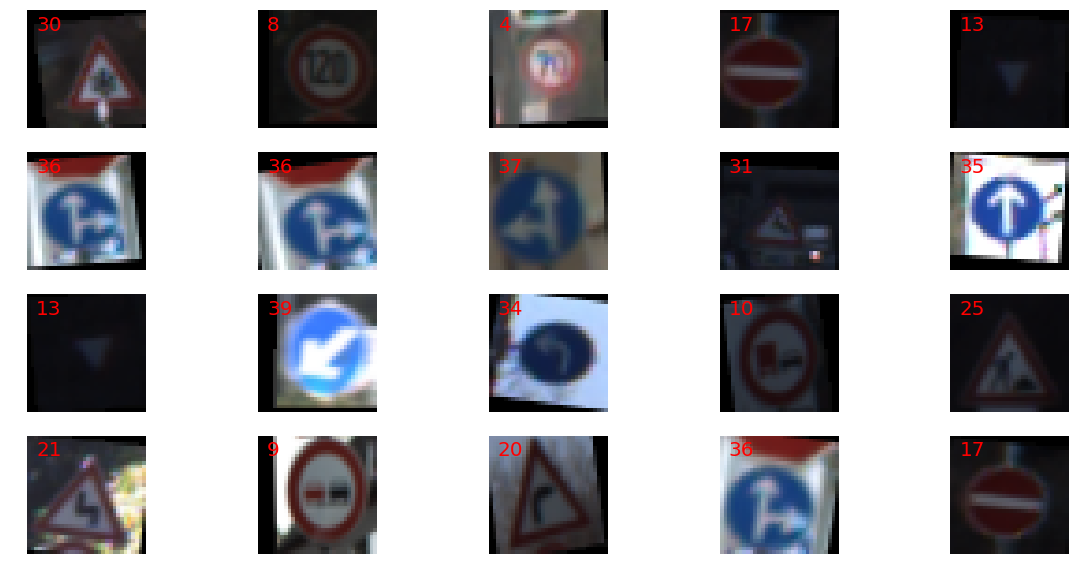

In [29]:
# Visualize 20 examples picked randomly from train dataset
ls = [random.randint(0,len(y_extra)) for i in range(20)]
visualize_random_images(list_imgs=ls,X_dataset=X_extra,y_dataset=y_extra)

In [30]:
if X_extra is not None:
    X_train = np.concatenate((X_train,X_extra.astype('uint8')),axis=0)
    y_train = np.concatenate((y_train,y_extra),axis=0)
    del X_extra,y_extra

# visualization after data augmentation
>* Display 20 random images
>* show frequency of each class

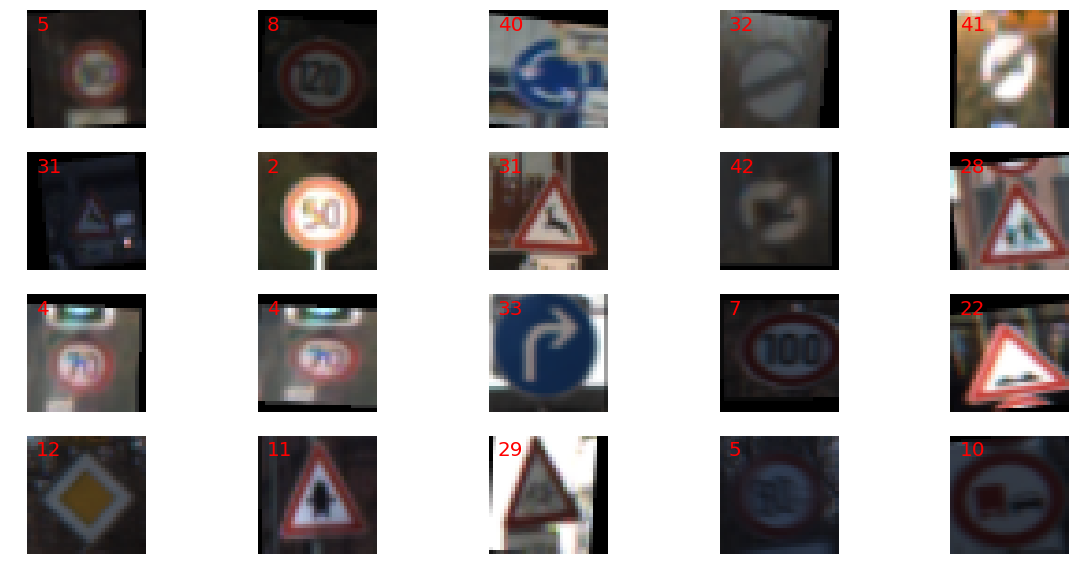

*** Train dataset after augmentation
	 Total Number of images in Train dataset:172000


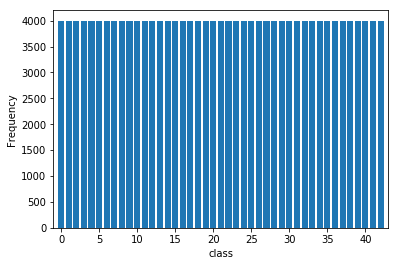

*** Validation dataset


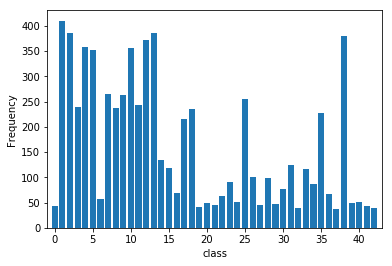

In [31]:
ls = [random.randint(0,len(y_train)) for i in range(20)]
visualize_random_images(list_imgs=ls,X_dataset=X_train,y_dataset=y_train)

print('*** Train dataset after augmentation')
print('\t Total Number of images in Train dataset:{}'.format(X_train.shape[0]))

plt.bar(np.arange(n_classes),get_count_imgs_per_class(y_train),align='center')
plt.xlabel('class')
plt.ylabel('Frequency')
plt.xlim([-1,43])
plt.show()

print('*** Validation dataset')
plt.bar(np.arange(n_classes),get_count_imgs_per_class(y_validation),align='center')
plt.xlabel('class')
plt.ylabel('Frequency')
plt.xlim([-1,43])
plt.show()

In [32]:
def preprocessed(dataset):
    n_imgs,img_height,img_width,_ = dataset.shape
    processed_dataset = np.zeros((n_imgs,img_height,img_width,1))
    for idx in range(len(dataset)):
        img = dataset[idx]
        gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
        
        processed_dataset[idx,:,:,0] = gray/255. - 0.5
    return processed_dataset

# Design and test model architecture


In [33]:
# Variables Initialization function and Operation
def weight_variable(shape,mean,stddev,name,seed=SEED):
    init = tf.truncated_normal(shape,mean=mean,stddev=stddev,seed=SEED)
    return tf.Variable(init,name=name)

def bias_variable(shape,init_value,name):
    init = tf.constant(init_value,shape=shape)
    return tf.Variable(init,name=name)

def conv2d(x,W,strides,padding,name):
    return tf.nn.conv2d(x,W,strides=strides,padding=padding,name=name)

def max_2x2_pool(x,padding,name):
    return tf.nn.max_pool(x,ksize=[1,2,2,1],strides=[1,2,2,1],padding=padding,name=name)

In [34]:
#weights and biases
#parameters

IMG_DEPTH = 1
mu =0
sigma = 0.05
bias_init = 0.05

weights ={  
    'W_conv1': weight_variable([3, 3, IMG_DEPTH, 80], mean=mu, stddev=sigma, name='W_conv1'),
    'W_conv2': weight_variable([3, 3, 80, 120], mean=mu, stddev=sigma, name='W_conv2'),
    'W_conv3': weight_variable([4, 4, 120, 180], mean=mu, stddev=sigma, name='W_conv3'),
    'W_conv4': weight_variable([3, 3, 180, 200], mean=mu, stddev=sigma, name='W_conv4'),
    'W_conv5': weight_variable([3, 3, 200, 200], mean=mu, stddev=sigma, name='W_conv5'),
    'W_fc1': weight_variable([800, 80], mean=mu, stddev=sigma, name='W_fc1'),
    'W_fc2': weight_variable([80, 80], mean=mu, stddev=sigma, name='W_fc2'),
    'W_fc3': weight_variable([80, 43], mean=mu, stddev=sigma, name='W_fc3'),
}
biases = {
    'b_conv1': bias_variable(shape=[80], init_value=bias_init, name='b_conv1'),
    'b_conv2': bias_variable(shape=[120], init_value=bias_init, name='b_conv2'),
    'b_conv3': bias_variable(shape=[180], init_value=bias_init, name='b_conv3'),
    'b_conv4': bias_variable(shape=[200], init_value=bias_init, name='b_conv4'),
    'b_conv5': bias_variable(shape=[200], init_value=bias_init, name='b_conv5'),
    'b_fc1': bias_variable([80], init_value=bias_init, name='b_fc1'),
    'b_fc2': bias_variable([80], init_value=bias_init, name='b_fc2'),
    'b_fc3': bias_variable([43], init_value=bias_init, name='b_fc3'),
}


In [35]:
def traffic_model(x,keep_prob,keep_p_conv,weights,biases):
    '''
    ConvNet model for Traffic sign classifier
    x - input image is tensor of shape(n_imgs,img_height,img_width,img_depth)
    keep_prob - hyper parameter of the dropout operation
    weights - dictionary of the weights for convolution layers and fully connected layers
    biases dictionary of the biases for convolutional layers and fully connected layers
    '''
    # Convolutional block 1
    conv1 = conv2d(x, weights['W_conv1'], strides=[1,1,1,1], padding='VALID', name='conv1_op')
    conv1_act = tf.nn.relu(conv1 + biases['b_conv1'], name='conv1_act')
    conv1_drop = tf.nn.dropout(conv1_act, keep_prob=k_p_conv, name='conv1_drop')
    conv2 = conv2d(conv1_drop, weights['W_conv2'], strides=[1,1,1,1], padding='SAME', name='conv2_op')
    conv2_act = tf.nn.relu(conv2 + biases['b_conv2'], name='conv2_act')
    conv2_pool = max_2x2_pool(conv2_act, padding='VALID', name='conv2_pool')
    pool2_drop = tf.nn.dropout(conv2_pool, keep_prob=k_p_conv, name='conv2_drop')
    
    #Convolution block 2
    conv3 = conv2d(pool2_drop, weights['W_conv3'], strides=[1,1,1,1], padding='VALID', name='conv3_op')
    conv3_act = tf.nn.relu(conv3 + biases['b_conv3'], name='conv3_act')
    conv3_drop = tf.nn.dropout(conv3_act, keep_prob=k_p_conv, name='conv3_drop')
    conv4 = conv2d(conv3_drop, weights['W_conv4'], strides=[1,1,1,1], padding='SAME', name='conv4_op')
    conv4_act = tf.nn.relu(conv4 + biases['b_conv4'], name='conv4_act')
    conv4_pool = max_2x2_pool(conv4_act, padding='VALID', name='conv4_pool')
    conv4_drop = tf.nn.dropout(conv4_pool, keep_prob, name='conv4_drop')
    
    conv5 = conv2d(conv4_drop, weights['W_conv5'], strides=[1,1,1,1], padding='VALID', name='conv5_op')
    conv5_act = tf.nn.relu(conv5 + biases['b_conv5'], name='conv5_act')
    conv5_pool = max_2x2_pool(conv5_act, padding='VALID', name='conv5_pool')
    conv5_drop = tf.nn.dropout(conv5_pool, keep_prob, name='conv5_drop')
    
    #Fully connected layers
    fc0 = flatten(conv5_drop)
    fc1 = tf.nn.relu( tf.matmul( fc0, weights['W_fc1'] ) + biases['b_fc1'], name='fc1' )
    fc1_drop = tf.nn.dropout(fc1, keep_prob, name='fc1_drop')
    fc2 = tf.nn.relu( tf.matmul( fc1_drop, weights['W_fc2'] ) + biases['b_fc2'], name='fc2' )
    fc2_drop = tf.nn.dropout(fc2, keep_prob, name='fc2_drop')
    logits = tf.add(tf.matmul(fc2_drop, weights['W_fc3']),biases['b_fc3'], name='logits')  
    
    return [weights, logits]

In [36]:
# Train your model here
x = tf.placeholder(tf.float32,(None,IMG_HEIGHT,IMG_WIDTH,IMG_DEPTH),name='x')
y = tf.placeholder(tf.int32,(None),name='y')
keep_prob = tf.placeholder(tf.float32,name='keep_prob')
k_p_conv = tf.placeholder(tf.float32,name='k_p_conv')
one_hot_y = tf.one_hot(y,n_classes)
rate = tf.placeholder(tf.float32,name='rate')

weights,logits = traffic_model(x,keep_prob,k_p_conv,weights,biases)
softmax_operation = tf.nn.softmax(logits)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits = logits,labels = one_hot_y)
beta = 0.0001
loss_reg = beta*(tf.nn.l2_loss(weights['W_fc1'])+tf.nn.l2_loss(weights['W_fc2'])+tf.nn.l2_loss(weights['W_fc3']))
loss = tf.reduce_mean(cross_entropy)+loss_reg

optimizer = tf.train.AdamOptimizer(learning_rate=rate)
training_operation = optimizer.minimize(loss)

In [37]:
correct_prediction = tf.equal(tf.argmax(logits,1),tf.argmax(one_hot_y,1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction,tf.float32))

def evaluate(X_data,y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    total_l = 0
    for offset in range(0,num_examples,BATCH_SIZE):
        batch_x,batch_y = X_data[offset:offset+BATCH_SIZE],y_data[offset:offset+BATCH_SIZE]
        accuracy,l = sess.run([accuracy_operation,loss],feed_dict={x:batch_x,y:batch_y,k_p_conv:1,keep_prob:1})
        total_accuracy+=(accuracy*len(batch_x))
        total_l +=l*len(batch_x)
    return [total_accuracy/num_examples,total_l/num_examples]

In [38]:
'''
histogram equalzier turn off
EPOCHs=100
l_rate decreases from 0.001 to l_rate/5 at 30 EPOCH and 50 EPOCHS
Keep same class distribution as original dataset:augmentation=6X
No keep prob for conv
'''
EPOCHS = 25
BATCH_SIZE = 200
model_nbr = 'ora'

In [39]:
with tf.Session() as sess:
    saver = tf.train.Saver()
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    print('Training... \n')
    summary_train = []
    l_rate = 0.001
    keep_rate = 0.5
    kp_conv  = 0.6
    print('Pre-processing X_train...')
    X_train_prep = preprocessed(X_train).reshape(-1,IMG_HEIGHT,IMG_WIDTH,IMG_DEPTH)
    X_val_prep = preprocessed(X_validation).reshape(-1,IMG_HEIGHT,IMG_WIDTH,IMG_DEPTH)
    print('X_train preprocessed dataset size:{}|data type:{}'.format(X_train_prep.shape,X_train_prep.dtype))
    print('End preprocessing X_train...')
    
    #map for reduction of l_rate at different EPOCHS(first elt)
    
    for i in range(EPOCHS):
        #scheme to decrease learning rate by step
        if i >=40:
            l_rate = 0.0001
        
        X_train_prep,y_train = shuffle(X_train_prep,y_train)
        
        for offset in range(0,num_examples,BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x,batch_y = X_train_prep[offset:end],y_train[offset:end]
            
            sess.run(training_operation,feed_dict={x:batch_x,y:batch_y,keep_prob:keep_rate,\
                                                  k_p_conv:kp_conv,rate:l_rate})
        
        train_accuracy,train_loss = evaluate(X_train_prep,y_train)
        
        validation_accuracy,validation_loss = evaluate(X_val_prep,y_validation)
        
        print('EPOCH{}...'.format(i+1))
        print('Train accuracy:{:.4f}|Validation Accuracy={:.4f}'.format(train_accuracy,validation_accuracy))
        print('Train loss:{:.5f}|Validation loss = {:.5f}\n'.format(train_loss,validation_loss))
        summary_train.append([i+1,train_accuracy,validation_accuracy,train_loss,validation_loss])
        
    summary_train = np.array(summary_train)
    np.save('summary_train_'+model_nbr+'.npy',summary_train)
    saver.save(sess,save_path='./traffic_model'+model_nbr)
    print('Model saved')


Training... 

Pre-processing X_train...
X_train preprocessed dataset size:(172000, 32, 32, 1)|data type:float64
End preprocessing X_train...
EPOCH1...
Train accuracy:0.7868|Validation Accuracy=0.1731
Train loss:0.79361|Validation loss = 3.19590

EPOCH2...
Train accuracy:0.8811|Validation Accuracy=0.3345
Train loss:0.44454|Validation loss = 2.42503

EPOCH3...
Train accuracy:0.9135|Validation Accuracy=0.4595
Train loss:0.33171|Validation loss = 1.88886

EPOCH4...
Train accuracy:0.9334|Validation Accuracy=0.5833
Train loss:0.24098|Validation loss = 1.38071

EPOCH5...
Train accuracy:0.9492|Validation Accuracy=0.6789
Train loss:0.19259|Validation loss = 1.07773

EPOCH6...
Train accuracy:0.9642|Validation Accuracy=0.7690
Train loss:0.15119|Validation loss = 0.82031

EPOCH7...
Train accuracy:0.9738|Validation Accuracy=0.8343
Train loss:0.11789|Validation loss = 0.60727

EPOCH8...
Train accuracy:0.9834|Validation Accuracy=0.8960
Train loss:0.08836|Validation loss = 0.42916

EPOCH9...
Train acc

# Test

In [40]:
with tf.Session() as sess:
    
    loader = tf.train.import_meta_graph('traffic_model'+model_nbr+'.meta')
    sess.run(tf.global_variables_initializer())
    loader.restore(sess,tf.train.latest_checkpoint(checkpoint_dir='./'))
    X_test_prep = preprocessed(X_test).reshape(-1,IMG_HEIGHT,IMG_WIDTH,1)
    test_accuracy,_=evaluate(X_test_prep,y_test)
    
    #select 20 random images
    ls = [random.randint(0,len(y_test)) for i in range(20)]
    X_test_select = np.zeros((20,IMG_HEIGHT,IMG_WIDTH,1))
    y_test_select = np.zeros((20,1))
    
    for i in range(len(ls)):
        X_test_select[i] = X_test_prep[ls[i]]
        y_test_select[i] = y_test[ls[i]]
    
    test_pred_proba = sess.run(softmax_operation,feed_dict={x:X_test_select,k_p_conv:1,keep_prob:1})
    prediction_test = np.argmax(test_pred_proba,1)
    print('Test Accuracy={:.4f}'.format(test_accuracy))

INFO:tensorflow:Restoring parameters from ./traffic_modelora
Test Accuracy=0.9632


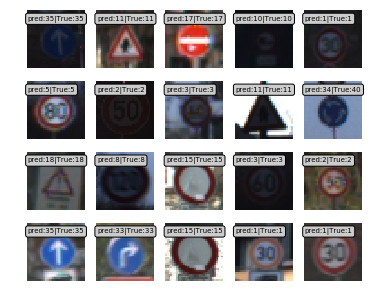

In [41]:
#Visualization
#random select images and their predicted labels
_,ax = plt.subplots(len(ls)//5,5,figsize=(6,5))
row,col = 0,0
for i ,idx in enumerate(ls):
    img = X_test[idx]
    ax[row,col].imshow(img,cmap='gray')
    annot = 'pred:'+str(int(prediction_test[i]))+'|True:'+str(y_test[idx])
    ax[row,col].annotate(annot,xy=(0,5),color='black',fontsize='7',bbox=dict(boxstyle='round',fc='0.8'))
    
    ax[row,col].axis('off')
    col+=1
    if col == 5:
        row,col = row+1,0
plt.show()

In [42]:
import os

IMG_HEIGHT = 32
IMG_WIDTH = 32

def get_list_files(my_dir,f_ext):
    list_f = []
    for file in os.listdir(my_dir):
        if file.endswith('.'+f_ext):
            list_f.append(file)
    return list_f

my_dir = 'extra'

file_list = get_list_files(my_dir,'png')

X_extra = np.zeros((len(file_list),IMG_HEIGHT,IMG_WIDTH,3),dtype='uint8')

for idx,file in enumerate(file_list):
    img = cv2.imread(my_dir+'/'+file)
    img = cv2.resize(img,(32,32))
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    X_extra[idx] = img

print('Extra dataset size:{}|Datatype:{}'.format(X_extra.shape,X_extra.dtype))
#Data pre-processing
X_extra_prep = preprocessed(X_extra).reshape(-1,IMG_HEIGHT,IMG_WIDTH,1)
print('Preprocessed Extra dataset size:{}|Dtatype:{}'.format(X_extra_prep.shape,X_extra_prep.dtype))

Extra dataset size:(10, 32, 32, 3)|Datatype:uint8
Preprocessed Extra dataset size:(10, 32, 32, 1)|Dtatype:float64


Original (left) and pre-processed(right) iamges


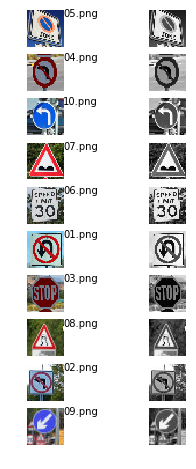

In [43]:
#Visualize images:original(left) and after pre-processing(right)

#initialize subplots
_,ax = plt.subplots(len(file_list),2,figsize=(4,8))
col_plot = 0
print('Original (left) and pre-processed(right) iamges')
for i in range(len(X_extra)):
    img = X_extra[i]
    ax[i,col_plot].imshow(img)
    ax[i,col_plot].annotate(file_list[i],xy=(31,5),color='black',fontsize='10')
    ax[i,col_plot].axis('off')
    col_plot +=1
    ax[i,col_plot].imshow(X_extra_prep[i,:,:,0],cmap='gray')
    ax[i,col_plot].axis('off')
    col_plot = 0
plt.show()

# inference

INFO:tensorflow:Restoring parameters from ./traffic_modelora
Prediction on extra data


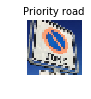

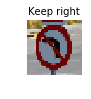

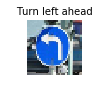

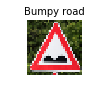

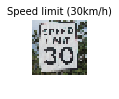

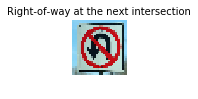

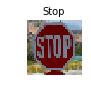

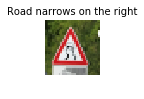

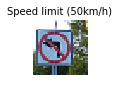

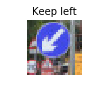

In [44]:
# inference
feed_dict = {x:X_extra_prep,keep_prob:1,k_p_conv:1}
k_top = 5
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    loader = tf.train.import_meta_graph('traffic_model'+model_nbr+'.meta')
    loader.restore(sess,tf.train.latest_checkpoint('./'))
    pred_proba = sess.run(softmax_operation,feed_dict=feed_dict)
    prediction = np.argmax(pred_proba,1)
    # top 5 probabilities
    top_k_values = tf.nn.top_k(softmax_operation,k_top)
    top_k_proba = sess.run([softmax_operation,top_k_values],feed_dict=feed_dict)

#Visualize image with predicted label
print('Prediction on extra data')
for i in range(len(X_extra)):
    plt.figure(figsize=(1,1))
    img = X_extra[i]
    plt.imshow(img)
    plt.title(sign_names[prediction[i]][1],fontsize=10)
    plt.axis('off')
    plt.show()